# Ciencia de Datos

## CIDE - David Guzmán

### Selección de modelos y regresión lineal

En este notebook, se da un repaso sobre:
* Entrenamiento y validación del modelo
* Best Subset Selection y Validación Cruzada
* PCA
* Regularización
* Regularización con PCA

# Problema 1. Training vs Validation

En la clase calculamos la frontera de SSR ante el número de regresores, para la muestra de entrenamiento. 

![figure1](figure1.png)

Divide la muestra en training y testing y gráfica como se vería la frontera de SSR para una muestra de entrenamiento y de validación. Es decir, haz una línea de SSR potencial para ambas muestras



Pista: Usa la función train_test_split de sklearn 
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('Credit.csv')
data.head(5)

,Income,Limit,Rating,Cards,Age,Education,Own,Student,Married,Region,Balance
0,14.89,3606,283,2,34,11,No,No,Yes,South,333
1,106.03,6645,483,3,82,15,Yes,Yes,Yes,West,903
2,104.59,7075,514,4,71,11,No,No,No,West,580
3,148.92,9504,681,3,36,11,Yes,No,No,West,964
4,55.88,4897,357,2,68,16,No,No,Yes,South,331


In [ ]:
# primero organicemos los datos: las variables cuantitativas están bien.  Las cualitativas toca transformarlas
N = data.shape[0]
dum_own     = np.asarray(data.Own == 'Yes').reshape((N,1))
dum_estudiante = np.asarray(data.Student == 'Yes').reshape((N,1))
dum_casado     = np.asarray(data.Married == 'Yes').reshape((N,1))
# Para etnicidad debemos excluir una variable que sirva como referencia:
# tenemos tres categorías: vamos a excluir la tercera: "African American"
print(data.Region.unique())
dum_region = np.asarray(pd.get_dummies(data.Region).iloc[:,:-1])
# etiquetas de X
labs_x = np.array(['Rating','Income','Limit','Cards','Age','Education',
              'Own','Estudiante','Casado','South','West'])
# incluyamos todas las variables:
prexmat = np.concatenate((
                        np.asarray(data.Rating).reshape((N,1)),
                        np.asarray(data.Income).reshape((N,1)),
                         np.asarray(data.Limit).reshape((N,1)),
                         np.asarray(data.Cards).reshape((N,1)),
                         np.asarray(data.Age).reshape((N,1)),
                         np.asarray(data.Education).reshape((N,1)),
                          dum_own, dum_estudiante, dum_casado, dum_region
                         ),axis=1)
saldo = np.asarray(data.Balance).reshape((N,1))
print(prexmat.shape)
# revisemos que todo quedó bien:
pd.DataFrame(prexmat).mean()

['South' 'West' 'East']
(400, 11)


0      354.94
1       45.22
2    4,735.60
3        2.96
4       55.67
5       13.45
6        0.52
7        0.10
8        0.61
9        0.25
10       0.50
dtype: float64

In [ ]:
# Para las posibles combinaciones vamos a usar el módulo itertools
from itertools import combinations
import sys
sys.path.append('/Users/carlosograndetcaballero/Documents/CIDE_DS/Utils')
import olsdan as ols

# probémoslo con conjuntos de 9 elementos
list(combinations(np.arange(10),9))

# vamos a guardar los resultados en un array, pero no se cuántas filas tenemos
res_arr = np.zeros((1,6))
res_arr[:,:] = np.nan
# necesito una lista con todas las combinaciones.  La voy a guardar en un DF
initsub = np.zeros((0,9))
initsub[:] = np.nan
SubSets = pd.DataFrame(initsub)
for k in range(1,12):
    # la siguiente es la lista de todos los regresores posibles para tamaño k
    list_subsets = list(combinations(np.arange(11),k))
    SubSets = SubSets.append(list_subsets)
    # tenemos que hacer un loop sobre todas estas posibilidades:
    for s in range(len(list_subsets)):
        # los regresores seleccionados:
        ind_s = np.array(list_subsets[s])
        xmat_subset = prexmat[:,ind_s]
        # listos para estimar: pero incluyamos constante
        olssk = ols.ols_dan(saldo, np.concatenate((np.ones((N,1)),xmat_subset),axis=1))
        # guardemos los resultados: queremos: número de regresores, ssr
        # Calculemos las medidas que queremos utilizar
        Cp = (1.0/olssk.nobs)*(olssk.ssr() + 2*olssk.nvar*olssk.s2hat())
        AIC = (1.0/(olssk.nobs*olssk.s2hat()))*(olssk.ssr() + 2*olssk.nvar*olssk.s2hat())
        BIC = (1.0/olssk.nobs)*(olssk.ssr() + np.log(olssk.nobs)*olssk.nvar*olssk.s2hat())
        R2bar = olssk.R2_bar()
        prelist = np.array([k, olssk.ssr()[0][0], Cp[0,0], AIC[0,0], BIC[0,0], R2bar]).reshape((1,6))
        # listos para anexar:
        res_arr = np.concatenate((res_arr, prelist),axis=0)
res_arr = pd.DataFrame(res_arr, columns=['k', 'SSR', 'Cp', 'AIC', 'BIC', 'R2bar'])
res_arr.dropna(inplace=True)
res_arr.set_index(np.arange(res_arr.shape[0]), inplace=True)
print(res_arr.shape)

(2047, 6)


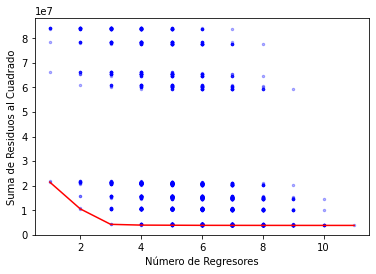

In [ ]:
# Ya tenemos todos los modelos:
# Hagamos un gráfico:
plt.scatter(res_arr.k,res_arr.SSR, s=6, color='b',alpha=0.3)
plt.ylabel('Suma de Residuos al Cuadrado')
plt.xlabel(u'Número de Regresores')
# Encontremos la frontera: como en el libro:
front_ssr = res_arr.SSR.groupby(res_arr.k).min()
plt.plot(front_ssr.index, front_ssr.values, color='r')       

In [ ]:
# primero organicemos los datos: las variables cuantitativas están bien.  Las cualitativas toca transformarlas
N = data.shape[0]
dum_own     = np.asarray(data.Own == 'Yes').reshape((N,1))
dum_estudiante = np.asarray(data.Student == 'Yes').reshape((N,1))
dum_casado     = np.asarray(data.Married == 'Yes').reshape((N,1))
# Para etnicidad debemos excluir una variable que sirva como referencia:
# tenemos tres categorías: vamos a excluir la tercera: "African American"
print(data.Region.unique())
dum_region = np.asarray(pd.get_dummies(data.Region).iloc[:,:-1])
# etiquetas de X
labs_x = np.array(['Rating','Income','Limit','Cards','Age','Education',
              'Own','Estudiante','Casado','South','West'])
# incluyamos todas las variables:
prexmat = np.concatenate((
                        np.asarray(data.Rating).reshape((N,1)),
                        np.asarray(data.Income).reshape((N,1)),
                         np.asarray(data.Limit).reshape((N,1)),
                         np.asarray(data.Cards).reshape((N,1)),
                         np.asarray(data.Age).reshape((N,1)),
                         np.asarray(data.Education).reshape((N,1)),
                          dum_own, dum_estudiante, dum_casado, dum_region
                         ),axis=1)
saldo = np.asarray(data.Balance).reshape((N,1))
print(prexmat.shape)
# revisemos que todo quedó bien:
pd.DataFrame(prexmat).mean()

['South' 'West' 'East']
(400, 11)


0      354.94
1       45.22
2    4,735.60
3        2.96
4       55.67
5       13.45
6        0.52
7        0.10
8        0.61
9        0.25
10       0.50
dtype: float64

In [ ]:
prexmat.shape

(400, 11)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(prexmat, saldo, test_size=0.30, random_state=45)

In [ ]:
len(X_train), len(y_train), len(X_test), len(y_test)

(280, 280, 120, 120)

In [ ]:
from sklearn.linear_model import LinearRegression

N_train = len(X_train)
N_test = len(X_test)
# probémoslo con conjuntos de 9 elementos
list(combinations(np.arange(10),9))

# vamos a guardar los resultados en un array, pero no se cuántas filas tenemos
res_arr_test = np.zeros((1,3))
res_arr_test[:,:] = np.nan


# necesito una lista con todas las combinaciones.  La voy a guardar en un DF
initsub = np.zeros((0,9))
initsub[:] = np.nan
SubSets = pd.DataFrame(initsub)
for k in range(1,12):
    # la siguiente es la lista de todos los regresores posibles para tamaño k
    list_subsets = list(combinations(np.arange(11),k))
    SubSets = SubSets.append(list_subsets)
    # tenemos que hacer un loop sobre todas estas posibilidades:
    for s in range(len(list_subsets)):
        # los regresores seleccionados:
        ind_s = np.array(list_subsets[s])
        X_train_subset = X_train[:,ind_s]
        X_test_subset = X_test[:,ind_s]
        # listos para estimar: pero incluyamos constante
        reg = LinearRegression(fit_intercept = False).fit( 
                                                          np.concatenate((np.ones((N_train,1)),X_train_subset),axis=1),
        y_train)
        y_train_hat = reg.predict(np.concatenate((np.ones((N_train,1)),X_train_subset),axis=1))
        
        
        y_test_hat = reg.predict(np.concatenate((np.ones((N_test,1)),X_test_subset),axis=1))
        
        # guardemos los resultados: queremos: número de regresores, ssr
        # Calculemos las medidas que queremos utilizar
        mse_train = np.mean((y_train_hat - y_train) ** 2)
        mse_test = np.mean((y_test_hat - y_test) ** 2)
        prelist = np.array([k, mse_train,mse_test]).reshape((1,3))
        # listos para anexar:
        res_arr_test = np.concatenate((res_arr_test, prelist),axis=0)
res_arr_test = pd.DataFrame(res_arr_test, columns=['k', 'SSR_train', 'SSR_test'])
res_arr_test.dropna(inplace=True)
res_arr_test.set_index(np.arange(res_arr_test.shape[0]), inplace=True)
print(res_arr_test.shape)

(2047, 3)


In [ ]:
res_arr_test

,k,SSR_train,SSR_test
0,1.00,"51,192.42","60,758.51"
1,1.00,"159,297.09","183,506.81"
2,1.00,"51,742.40","61,671.76"
3,1.00,"206,245.28","219,302.37"
4,1.00,"207,700.30","221,359.71"
...,...,...,...
2042,10.00,"10,805.58","8,319.40"
2043,10.00,"11,254.91","8,651.28"
2044,10.00,"37,051.56","37,375.87"
2045,10.00,"10,564.06","8,073.75"


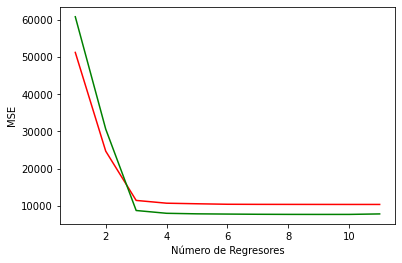

In [ ]:
# Ya tenemos todos los modelos:
# Hagamos un gráfico:
plt.ylabel('MSE')
plt.xlabel(u'Número de Regresores')
# Encontremos la frontera: como en el libro:
front_ssr_train = res_arr_test.SSR_train.groupby(res_arr.k).min()
plt.plot(front_ssr_train.index, front_ssr_train.values, color='r') 
front_ssr_test = res_arr_test.SSR_test.groupby(res_arr.k).min()
plt.plot(front_ssr_test.index, front_ssr_test.values, color='g') 

In [ ]:
res_arr_test

,k,SSR_train,SSR_test
0,1.00,"51,192.42","60,758.51"
1,1.00,"159,297.09","183,506.81"
2,1.00,"51,742.40","61,671.76"
3,1.00,"206,245.28","219,302.37"
4,1.00,"207,700.30","221,359.71"
...,...,...,...
2042,10.00,"10,805.58","8,319.40"
2043,10.00,"11,254.91","8,651.28"
2044,10.00,"37,051.56","37,375.87"
2045,10.00,"10,564.06","8,073.75"


In [ ]:
res_arr_test.SSR_train.groupby(res_arr.k).min()

k
1.00    51,192.42
2.00    24,722.73
3.00    11,512.76
4.00    10,768.33
5.00    10,615.73
6.00    10,482.94
7.00    10,457.57
8.00    10,449.31
9.00    10,442.14
10.00   10,435.90
11.00   10,435.50
Name: SSR_train, dtype: float64

# Problema 2: Best Subset Selection y Validación Cruzada

En las Notas mostré cómo se ejecuta el algoritmo de Best Subset Selection.




Ahora vamos a decidir cuál es el número óptimo de regresores utilizando validación cruzada con 10 grupos.

1. Seleccione los modelos en la frontera.  Recuerde que cada modelo no es más que un subconjunto de índices sobre los regresores. 

(Ayuda: hay varias formas de hacer esto.  Una es identificar los modelos de acuerdo al SSR mínimo--- así lo hicimos gráficamente.  Si desea seguir este camino, puede que la función `r = np.in1d(A,B)` le sirva.  Esta función devuelve un vector booleano donde $r_i = 1$ cuando $a_i \in B$, es decir, cuando el elemento correspondiente de A se encuentra en B.)

Un modo más sencillo sería usar el cross_validation score de sklearn https://scikit-learn.org/stable/modules/cross_validation.html

2. Una vez identificados, realice CV con 10 grupos sobre estos modelos, e identifice **gráficamente** el modelo que minimiza el error de CV.

Al final debería quedarte algo como esto

![fig](figure2.png)

In [ ]:
SubSets

,0,1,2,3,4,5,6,7,8,9,10
0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
7,0.00,1.00,2.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,NaN
8,0.00,1.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,NaN
9,0.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,NaN
10,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,NaN


Int64Index([0, 11, 71, 354, 564, 1025, 1490, 1826, 1990, 2035, 2046], dtype='int64')


Text(0, 0.5, 'SSR Promedio en Muestras de Validación')

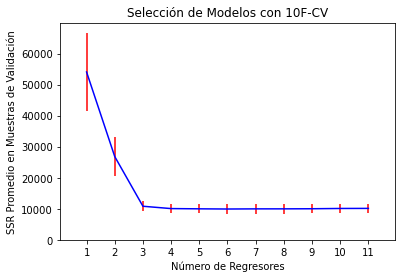

In [ ]:
# Cross-validation: necesitamos identificar primero los modelos en la frontera roja
# identifiquemos los índices primero: función np.in1d()
ind_best = np.in1d(res_arr.SSR.values,front_ssr.values)
# teniendo los índices podemos encontrar: los 10 mejores
ind_best = res_arr.index[ind_best]
print(ind_best)
# Vamos a hacer 10-fold CV así que asignemos grupos.
grp_sel = np.dot(np.random.multinomial(1,[1.0/10]*10,N),np.arange(1,11).reshape((10,1)))
# Inicialicemos la matriz donde vamos a guardar los resultados.
SSRCV = np.zeros((10,11))  # CV groups x Number of variables
# Teníamos unos índices equivocados.  Vamos a hacerlo de 0 a M (M es el número total de modelos o combinaciones)
SubSets.set_index(np.arange(SubSets.shape[0]), inplace=True)
# Primer loop es sobre grupos de validación: g es el grupo que vamos a excluir de la muestra entrenamiento.
for g in range(1,11):
    # Seleccionemos las muestras desde ya
    ind_train = (grp_sel!=g).flatten()
    nobs_train = ind_train.sum()
    ind_valid = (grp_sel==g).flatten()
    nobs_valid = ind_valid.sum()
    # Ahora el loop sobre los modelos:
    counter = 0
    for m in ind_best:
        # Seleccionemos el modelo correspondiente sobre la frontera: necesitamos los índices de las variables
        ind_s = np.array(pd.Series(SubSets.loc[m]).dropna().values,dtype='int')
        # Asignemos la matrix X correspondiente
        xmat_subset = np.concatenate((np.ones((N,1)),prexmat[:,ind_s]),axis=1)
        # Restrinjamos la estimación a grupos de entrenamiento y validación
        xmat_train = xmat_subset[ind_train,:]
        xmat_valid = xmat_subset[ind_valid,:]
        y_train    = saldo[ind_train].reshape((nobs_train,1))
        y_valid    = saldo[ind_valid].reshape((nobs_valid,1))
        # La estimación es sobre TRAINING únicamente
        olssk = ols.ols_dan(y_train, xmat_train)
        # Obtengamos el resultado de la estimación sobre validación
        nvar  = olssk.nvar
        yhat_valid = np.dot(xmat_valid,olssk.betahat().reshape(nvar,1))
        diff       = y_valid - yhat_valid
        ssr_valid  = np.dot(diff.T,diff)/nobs_valid
        # Guardemos
        SSRCV[g-1,counter] = ssr_valid[0,0]
        counter +=1
# Listo:
# Ready to plot:
SSRCVm   = pd.DataFrame(SSRCV).mean(axis=0)
SSRCVstd = pd.DataFrame(SSRCV).sem(axis=0)
# plot SSRCV and std errors
plt.plot(np.arange(1,12), SSRCVm.values, color='b')
plt.bar(np.arange(1,12), SSRCVm.values, color='w', ec='w',yerr=1.96*SSRCVstd, ecolor='r', align='center')
plt.title(u'Selección de Modelos con 10F-CV')
plt.xticks(np.arange(1,12), np.arange(1,12))
plt.xlabel(u'Número de Regresores')
plt.ylabel(u'SSR Promedio en Muestras de Validación')

In [ ]:
pd.DataFrame(SSRCV)

,0,1,2,3,4,5,6,7,8,9,10
0,"60,982.96","24,536.88","10,078.67","8,745.00","8,774.51","8,482.77","8,404.41","8,588.26","9,075.36","9,047.53","9,026.56"
1,"85,361.84","49,981.35","12,007.85","12,006.40","11,601.24","11,515.56","11,355.48","11,348.67","11,243.71","11,357.94","11,406.19"
2,"66,698.51","31,370.49","6,437.36","6,687.90","6,326.24","5,950.69","5,994.18","6,243.49","6,301.90","6,244.69","6,537.92"
3,"29,079.78","18,892.36","12,515.88","13,265.52","12,913.48","13,011.51","13,386.35","13,279.16","13,202.66","13,169.74","13,148.84"
4,"58,133.60","28,873.02","9,899.85","7,472.98","8,000.08","7,909.46","7,826.79","7,817.98","7,775.02","7,722.19","7,688.58"
5,"29,625.70","25,504.72","11,081.47","10,683.58","10,422.03","9,954.47","10,145.00","10,268.38","10,410.10","10,735.55","10,693.61"
6,"78,437.79","32,326.45","11,498.78","8,699.21","9,141.81","9,856.89","9,733.60","9,618.67","9,544.34","9,522.38","9,492.25"
7,"35,580.78","11,931.64","10,407.32","10,558.74","10,242.24","10,327.52","10,612.74","10,610.03","10,595.14","10,545.95","10,493.08"
8,"38,041.91","21,689.94","9,266.85","9,751.20","9,427.43","9,008.08","8,986.34","8,875.04","8,828.61","9,416.39","9,474.50"
9,"59,795.64","24,382.79","16,411.88","14,196.66","14,449.81","14,678.64","14,723.44","14,581.56","14,576.31","14,713.42","14,734.64"


# Problema 3 PCA

Vamos a aplicar PCA a los datos de crédito para encontrar los principales componentes.
Primero, agarramos los datos de crédito y los procesamos

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('Credit.csv')

In [ ]:
# primero organicemos los datos: las variables cuantitativas están bien.  Las cualitativas toca transformarlas
N = data.shape[0]
dum_own     = np.asarray(data.Own == 'Yes').reshape((N,1))
dum_estudiante = np.asarray(data.Student == 'Yes').reshape((N,1))
dum_casado     = np.asarray(data.Married == 'Yes').reshape((N,1))
# Para etnicidad debemos excluir una variable que sirva como referencia:
# tenemos tres categorías: vamos a excluir la tercera: "African American"
print(data.Region.unique())
dum_region = np.asarray(pd.get_dummies(data.Region).iloc[:,:-1])
# etiquetas de X
labs_x = np.array(['Rating','Income','Limit','Cards','Age','Education'])
# incluyamos todas las variables:
prexmat = np.concatenate((
                        np.asarray(data.Rating).reshape((N,1)),
                        np.asarray(data.Income).reshape((N,1)),
                         np.asarray(data.Limit).reshape((N,1)),
                         np.asarray(data.Cards).reshape((N,1)),
                         np.asarray(data.Age).reshape((N,1)),
                         np.asarray(data.Education).reshape((N,1))
                         ),axis=1)

['South' 'West' 'East']


Tenemos los datos de la matriz de regresores, apliquemos PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(prexmat)

PCA(n_components=2)

El análisis nos muestra que el primer componente explica el 99% de la varianza, cómo interpretarías esto

In [ ]:
print(pca.explained_variance_ratio_)

[9.99828627e-01 8.98837797e-05]


Ahora vamos a ver los pesos. La tabla de abajo muestra cómo se compone los pesos de cada componente

In [ ]:
columns = ['Rating','Income','Limit','Cards','Age','Education']

In [ ]:
pca_scores = pca.components_ ** 2

In [ ]:
pd.options.display.float_format = '{:,.2f}%'.format

In [ ]:
pd.DataFrame( {"1st component" :pca_scores[0] * 100, "2nd component" : pca_scores[1] * 100}, index = columns) 

,1st component,2nd component
Rating,0.44%,0.11%
Income,0.01%,91.01%
Limit,99.54%,0.02%
Cards,0.00%,0.00%
Age,0.00%,8.86%
Education,0.00%,0.00%


Algo está raro con esta cálculo, nos dice que practicamente toda la varianza de los datos se explica por la variable limit. La razón es que faltó un paso clave en el procesamiento de los datos.
¿Cuál fue el paso clave? Pista: tiene que ver con diferentes escalas de cada variable

Corrige el problema y vuelve calcular los 2 y 3 componentes principales del modelo

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
prexmat_scaled = scaler.fit_transform(prexmat)


In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
pd.DataFrame(prexmat_scaled).std()

0   1.00
1   1.00
2   1.00
3   1.00
4   1.00
5   1.00
dtype: float64

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(prexmat_scaled)

PCA(n_components=2)

In [ ]:
print(pca.explained_variance_ratio_)

[0.45878779 0.17605291]


In [ ]:
columns = ['Rating','Income','Limit','Cards','Age','Education']

In [ ]:
pca_scores = pca.components_ ** 2

In [ ]:
pd.DataFrame( {"1st component" :pca_scores[0] * 100, "2nd component" : pca_scores[1] * 100}, index = columns) 

,1st component,2nd component
Rating,34.47%,0.03%
Income,29.47%,0.21%
Limit,34.44%,0.26%
Cards,0.04%,55.53%
Age,1.51%,7.18%
Education,0.07%,36.80%


# Problema 4 Regularización


En la clase, hicimos una regularización para un modelo grado 4, pero no optimizamos el alpha óptimo (el parámetro para la regularización). Usando validación cruzada encuentra el alpha óptimo para los siguientes modelos:

Lasso, Ridge y Elastic Net

¿Cuál es el mejor MSE y el alpha asociada para cada uno de estos 3 modelos?

Pista, puede usar la implementación de sklearn de estos 3 modelos

In [ ]:
# primero organicemos los datos: las variables cuantitativas están bien.  Las cualitativas toca transformarlas
N = data.shape[0]
dum_own     = np.asarray(data.Own == 'Yes').reshape((N,1))
dum_estudiante = np.asarray(data.Student == 'Yes').reshape((N,1))
dum_casado     = np.asarray(data.Married == 'Yes').reshape((N,1))
rating_2 = data.Rating ** 2
rating_3 = data.Rating ** 3
rating_4 = data.Rating ** 4
income_2 = data.Income ** 2
income_3 = data.Income ** 3
income_4 = data.Income ** 4
limit_2 = data.Limit ** 2
limit_3 = data.Limit ** 3
limit_4 = data.Limit ** 4

# Para etnicidad debemos excluir una variable que sirva como referencia:
# tenemos tres categorías: vamos a excluir la tercera: "African American"
print(data.Region.unique())
dum_region = np.asarray(pd.get_dummies(data.Region).iloc[:,:-1])
# etiquetas de X
labs_x = np.array(['Rating','Income','Limit','Cards','Age','Education',
              'Own','Estudiante','Casado','South','West'])
# incluyamos todas las variables:
prexmat_complex = np.concatenate((
                        np.asarray(data.Rating).reshape((N,1)),
                        np.asarray(data.Income).reshape((N,1)),
                         np.asarray(data.Limit).reshape((N,1)),
                         np.asarray(data.Cards).reshape((N,1)),
                         np.asarray(data.Age).reshape((N,1)),
                         np.asarray(data.Education).reshape((N,1)),
                        dum_own, dum_estudiante, dum_casado, dum_region, 
                         np.asarray(rating_2).reshape((N,1)), np.asarray(rating_3).reshape((N,1)),
                         np.asarray(rating_4).reshape((N,1)), np.asarray(income_2).reshape((N,1)),
                         np.asarray(income_3).reshape((N,1)), np.asarray(income_4).reshape((N,1)),
                         np.asarray(limit_2).reshape((N,1)), np.asarray(limit_3).reshape((N,1)),
                         np.asarray(limit_4).reshape((N,1)),
    
                         ),axis=1)

saldo = np.asarray(data.Balance).reshape((N,1))
print( prexmat_complex.shape)
# revisemos que todo quedó bien:
pd.DataFrame(prexmat_complex).mean()

['South' 'West' 'East']
(400, 20)


0                      354.94
1                       45.22
2                    4,735.60
3                        2.96
4                       55.67
5                       13.45
6                        0.52
7                        0.10
8                        0.61
9                        0.25
10                       0.50
11                 149,862.11
12              73,325,229.67
13          40,738,638,004.32
14                   3,283.80
15                 336,244.12
16              42,125,594.89
17              27,740,369.82
18         191,923,653,480.08
19   1,523,958,899,740,463.00
dtype: float64

In [ ]:
saldo.shape, prexmat_complex.shape

((400, 1), (400, 20))

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
prexmat_complex_scaled = scaler.fit_transform(prexmat_complex)
prexmat_complex_scaled = prexmat_complex

In [ ]:
pd.DataFrame(prexmat_complex_scaled).mean(), pd.DataFrame(prexmat_complex_scaled).std() 

(0                      354.94
 1                       45.22
 2                    4,735.60
 3                        2.96
 4                       55.67
 5                       13.45
 6                        0.52
 7                        0.10
 8                        0.61
 9                        0.25
 10                       0.50
 11                 149,862.11
 12              73,325,229.67
 13          40,738,638,004.32
 14                   3,283.80
 15                 336,244.12
 16              42,125,594.89
 17              27,740,369.82
 18         191,923,653,480.08
 19   1,523,958,899,740,463.00
 dtype: float64,
 0                      154.72
 1                       35.24
 2                    2,308.20
 3                        1.37
 4                       17.25
 5                        3.13
 6                        0.50
 7                        0.30
 8                        0.49
 9                        0.43
 10                       0.50
 11                 13

In [ ]:
from sklearn.linear_model import LassoCV
reg = LassoCV(alphas = [.01, .05, .1, .2, .3, .4, .5, .75, 1, 5, 10], 
              cv=10, random_state=0).fit(np.concatenate((np.ones((N,1)),prexmat_complex_scaled),axis=1), saldo)
reg.score(np.concatenate((np.ones((N,1)),prexmat_complex_scaled),axis=1), saldo)

In [ ]:
reg.alpha_

0.2

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import cross_validate
alpha = [.01, .05, .1, .2, .3, .4, .5, .75, 1, 5, 10]
results = pd.DataFrame(columns = ["alpha", "mse_ols", "mse_lasso", "mse_ridge", "mse_elastic"])
for i in alpha:
    print(i)
    
    ols = LinearRegression()
    cv_results_ols = cross_validate(ols, np.concatenate((np.ones((N,1)),prexmat_complex_scaled),axis=1), saldo, cv=5, 
                               scoring = "neg_mean_squared_error")
    
    ridge = Ridge(alpha= i)
    cv_results_ridge = cross_validate(ridge, np.concatenate((np.ones((N,1)),prexmat_complex_scaled),axis=1), saldo, cv=5, 
                               scoring = "neg_mean_squared_error")
    
    lasso = Lasso(alpha= i)
    cv_results_lasso = cross_validate(lasso, np.concatenate((np.ones((N,1)),prexmat_complex_scaled),axis=1), saldo, cv=5, 
                               scoring = "neg_mean_squared_error")
   
    elasticnet = ElasticNet(alpha= i)
    cv_results_en = cross_validate(elasticnet, np.concatenate((np.ones((N,1)),prexmat_complex_scaled),axis=1), saldo, cv=5, 
                               scoring = "neg_mean_squared_error")
   
    results = results.append({"alpha" :i, 
                              "mse_ols" : -cv_results_ols['test_score'].mean(),
                              "mse_lasso" : -cv_results_lasso['test_score'].mean(),
                              "mse_ridge" : -cv_results_ridge['test_score'].mean(), 
                              "mse_elastic" : -cv_results_en['test_score'].mean()}, ignore_index = True)
    

    

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
results

,alpha,mse_ols,mse_lasso,mse_ridge,mse_elastic
0,0.01,"21,601.60","5,134.65","4,818.63","5,192.77"
1,0.05,"21,601.60","5,133.06","4,818.71","6,044.50"
2,0.10,"21,601.60","5,131.23","4,818.91","7,522.38"
3,0.20,"21,601.60","5,127.85","4,819.65","10,180.35"
4,0.30,"21,601.60","5,126.23","4,820.84","12,151.99"
5,0.40,"21,601.60","5,126.02","4,822.46","13,606.73"
6,0.50,"21,601.60","5,124.35","4,824.50","14,711.98"
7,0.75,"21,601.60","5,122.14","4,831.40","16,563.22"
8,1.00,"21,601.60","5,125.96","4,840.75","17,705.61"
9,5.00,"21,601.60","5,453.18","5,231.99","21,392.10"


# Problema 5 Regularización con PCA

Repite el ejercicio de arriba, pero en lugar de usar la matriz de regresores grado 4, utiliza los primeros dos componentes principales de esa matriz. ¿Cómo cambia los resultados?

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
prexmat_complex_scaled = scaler.fit_transform(prexmat_complex)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
prexmat_complex_scaled_pca = pca.fit_transform(prexmat_complex_scaled)

In [ ]:
prexmat_complex_scaled_pca.shape

(400, 2)

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.model_selection import cross_validate
alpha = [.01, .05, .1, .2, .3, .4, .5, .75, 1, 5, 10]
results = pd.DataFrame(columns = ["alpha", "mse_ols", "mse_lasso", "mse_ridge", "mse_elastic"])
for i in alpha:
    print(i)
    
    ols = LinearRegression()
    cv_results_ols = cross_validate(ols, np.concatenate((np.ones((N,1)),prexmat_complex_scaled_pca),axis=1), saldo, cv=3, 
                               scoring = "neg_mean_squared_error")
    
    ridge = Ridge(alpha= i)
    cv_results_ridge = cross_validate(ridge, np.concatenate((np.ones((N,1)),prexmat_complex_scaled_pca),axis=1), saldo, cv=3, 
                               scoring = "neg_mean_squared_error")
    
    lasso = Lasso(alpha= i)
    cv_results_lasso = cross_validate(lasso, np.concatenate((np.ones((N,1)),prexmat_complex_scaled_pca),axis=1), saldo, cv=3, 
                               scoring = "neg_mean_squared_error")
   
    elasticnet = ElasticNet(alpha= i)
    cv_results_en = cross_validate(elasticnet, np.concatenate((np.ones((N,1)),prexmat_complex_scaled_pca),axis=1), saldo, cv=3, 
                               scoring = "neg_mean_squared_error")
   
    results = results.append({"alpha" :i, 
                              "mse_ols" : -cv_results_ols['test_score'].mean(),
                              "mse_lasso" : -cv_results_lasso['test_score'].mean(),
                              "mse_ridge" : -cv_results_ridge['test_score'].mean(), 
                              "mse_elastic" : -cv_results_en['test_score'].mean()}, ignore_index = True)

0.01
0.05
0.1
0.2
0.3
0.4
0.5
0.75
1
5
10


In [ ]:
results

,alpha,mse_ols,mse_lasso,mse_ridge,mse_elastic
0,0.01,"110,012.10","110,011.97","110,012.03","110,003.61"
1,0.05,"110,012.10","110,011.45","110,011.78","109,970.47"
2,0.10,"110,012.10","110,010.82","110,011.46","109,930.81"
3,0.20,"110,012.10","110,009.55","110,010.83","109,857.22"
4,0.30,"110,012.10","110,008.30","110,010.20","109,790.98"
5,0.40,"110,012.10","110,007.06","110,009.57","109,731.79"
6,0.50,"110,012.10","110,005.84","110,008.93","109,679.37"
7,0.75,"110,012.10","110,002.86","110,007.36","109,576.25"
8,1.00,"110,012.10","109,999.97","110,005.78","109,510.20"
9,5.00,"110,012.10","109,966.55","109,980.97","111,699.16"
